# Playground Series S6E1: Predicting Student Test Scores

**Challenge**: Predict student test scores using available features
**Metric**: Root Mean Squared Error (RMSE)
**Goal**: Build a baseline model and improve iteratively

---

## Workflow
1. Load and explore data (EDA)
2. Establish baseline model
3. Feature engineering & preprocessing
4. Model selection and tuning
5. Ensemble and final optimization

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Check if running on Kaggle
IS_KAGGLE = 'KAGGLE_DATA_PROXY_URL' in os.environ
print(f"Running on Kaggle: {IS_KAGGLE}")

# Detect environment paths
if IS_KAGGLE:
    DATA_PATH = Path('/kaggle/input/playground-series-s6e1/')
    OUTPUT_PATH = Path('/kaggle/working')
else:
    # Notebook lives in notebooks
    DATA_PATH = Path('data')
    OUTPUT_PATH = Path('submissions')

# Create output directory if it doesn't exist
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
print(f"Data path: {DATA_PATH}")
print(f"Output path: {OUTPUT_PATH}")

Running on Kaggle: True
Data path: /kaggle/input/playground-series-s6e1
Output path: /kaggle/working


In [3]:
# Load data
train_df = pd.read_csv(f'{DATA_PATH}/train.csv')
test_df = pd.read_csv(f'{DATA_PATH}/test.csv')
submission_sample = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')

print("Data Loaded Successfully!")
print(f"\nTrain shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Sample submission shape: {submission_sample.shape}")
print(f"\nTrain columns: {train_df.columns.tolist()}")
print(f"Test columns: {test_df.columns.tolist()}")
print(f"Submission columns: {submission_sample.columns.tolist()}")

Data Loaded Successfully!

Train shape: (630000, 13)
Test shape: (270000, 12)
Sample submission shape: (270000, 2)

Train columns: ['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'exam_score']
Test columns: ['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']
Submission columns: ['id', 'exam_score']


## 1. Exploratory Data Analysis (EDA)

In [4]:
# Display basic info
print("=" * 60)
print("TRAINING DATA INFO")
print("=" * 60)
print(f"\nShape: {train_df.shape}")
print(f"\nFirst few rows:")
print(train_df.head())
print(f"\nData types:")
print(train_df.dtypes)
print(f"\nMissing values:")
print(train_df.isnull().sum())
print(f"\nBasic statistics:")
print(train_df.describe())

TRAINING DATA INFO

Shape: (630000, 13)

First few rows:
   id  age  gender   course  study_hours  class_attendance internet_access  \
0   0   21  female     b.sc         7.91              98.8              no   
1   1   18   other  diploma         4.95              94.8             yes   
2   2   20  female     b.sc         4.68              92.6             yes   
3   3   19    male     b.sc         2.00              49.5             yes   
4   4   23    male      bca         7.65              86.9             yes   

   sleep_hours sleep_quality   study_method facility_rating exam_difficulty  \
0          4.9       average  online videos             low            easy   
1          4.7          poor     self-study          medium        moderate   
2          5.8          poor       coaching            high        moderate   
3          8.3       average    group study            high        moderate   
4          9.6          good     self-study            high            easy   



TARGET VARIABLE ANALYSIS

Duplicate rows: 0

Target variable (exam_score) statistics:
count    630000.000000
mean         62.506672
std          18.916884
min          19.599000
25%          48.800000
50%          62.600000
75%          76.300000
max         100.000000
Name: exam_score, dtype: float64


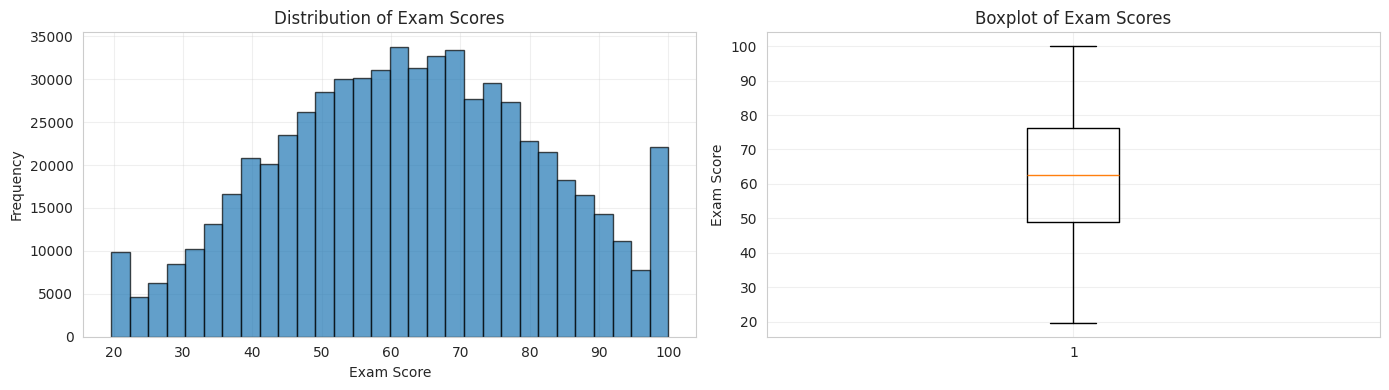

In [5]:
# Check for duplicates and analyze target variable
print("\n" + "=" * 60)
print("TARGET VARIABLE ANALYSIS")
print("=" * 60)
print(f"\nDuplicate rows: {train_df.duplicated().sum()}")
print(f"\nTarget variable (exam_score) statistics:")
print(train_df['exam_score'].describe())

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(train_df['exam_score'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Exam Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Exam Scores')
axes[0].grid(alpha=0.3)

axes[1].boxplot(train_df['exam_score'])
axes[1].set_ylabel('Exam Score')
axes[1].set_title('Boxplot of Exam Scores')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


FEATURE ANALYSIS

Numeric features (4): ['age', 'study_hours', 'class_attendance', 'sleep_hours']
Categorical features (7): ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']

CORRELATION WITH TARGET (exam_score)
exam_score          1.000000
study_hours         0.762267
class_attendance    0.360954
sleep_hours         0.167410
age                 0.010472
Name: exam_score, dtype: float64


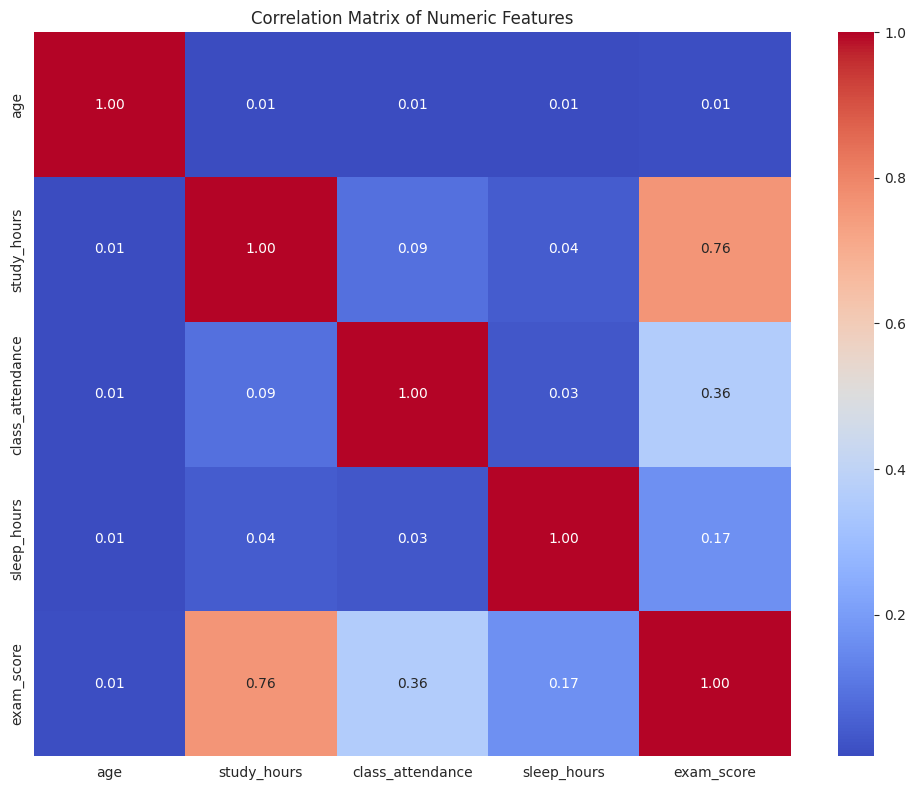

In [6]:
# Analyze features by type
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()

# Remove target and ID from feature list
numeric_features = [col for col in numeric_features if col not in ['exam_score', 'id']]
categorical_features = [col for col in categorical_features if col != 'id']

print("\n" + "=" * 60)
print("FEATURE ANALYSIS")
print("=" * 60)
print(f"\nNumeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Correlation with target
print("\n" + "=" * 60)
print("CORRELATION WITH TARGET (exam_score)")
print("=" * 60)
correlations = train_df[numeric_features + ['exam_score']].corr()['exam_score'].sort_values(ascending=False)
print(correlations)

# Visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[numeric_features + ['exam_score']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

## 2. Data Preprocessing

In [7]:
# Prepare data for modeling
def preprocess_data(df, categorical_features=None, numeric_features=None, fit_scalers=False, scalers=None):
    """
    Preprocess data: encode categorical variables and scale numeric features
    """
    df_processed = df.copy()
    
    # Encode categorical variables
    if categorical_features:
        le_dict = scalers.get('label_encoders', {}) if scalers else {}
        
        for col in categorical_features:
            if col in df_processed.columns:
                if fit_scalers:
                    le = LabelEncoder()
                    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
                    le_dict[col] = le
                else:
                    if col in le_dict:
                        df_processed[col] = le_dict[col].transform(df_processed[col].astype(str))
    
    # Scale numeric features
    if numeric_features:
        scaler = scalers.get('scaler') if scalers else None
        
        if fit_scalers:
            scaler = StandardScaler()
            df_processed[numeric_features] = scaler.fit_transform(df_processed[numeric_features])
        else:
            if scaler:
                df_processed[numeric_features] = scaler.transform(df_processed[numeric_features])
    
    return df_processed, {'scaler': scaler, 'label_encoders': le_dict} if fit_scalers else None

# Prepare training data
train_processed, scalers = preprocess_data(
    train_df,
    categorical_features=categorical_features,
    numeric_features=numeric_features,
    fit_scalers=True
)

# Prepare test data
test_processed, _ = preprocess_data(
    test_df,
    categorical_features=categorical_features,
    numeric_features=numeric_features,
    fit_scalers=False,
    scalers=scalers
)

print("Data preprocessing completed!")
print(f"\nProcessed training data shape: {train_processed.shape}")
print(f"Processed test data shape: {test_processed.shape}")

Data preprocessing completed!

Processed training data shape: (630000, 13)
Processed test data shape: (270000, 12)


## 3. Baseline Model

In [8]:
# Split data for baseline
X = train_processed[numeric_features + categorical_features]
y = train_processed['exam_score']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# Train baseline Linear Regression model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Make predictions
y_train_pred = baseline_model.predict(X_train)
y_val_pred = baseline_model.predict(X_val)

# Evaluate baseline
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("\n" + "=" * 60)
print("BASELINE MODEL PERFORMANCE (Linear Regression)")
print("=" * 60)
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Validation R²: {val_r2:.4f}")

Training set: (504000, 11)
Validation set: (126000, 11)

BASELINE MODEL PERFORMANCE (Linear Regression)
Training RMSE: 9.9596
Validation RMSE: 9.9452
Training R²: 0.7232
Validation R²: 0.7219


## 4. Submission Preparation

In [9]:
# Make predictions on test set
X_test = test_processed[numeric_features + categorical_features]
y_test_pred = baseline_model.predict(X_test)

# Create submission file
submission = submission_sample.copy()
submission['exam_score'] = y_test_pred

# Save submission
submission.to_csv(f'{OUTPUT_PATH}/submission.csv', index=False)
print(f"Baseline submission saved to {OUTPUT_PATH}/submission.csv")
print(f"\nSubmission shape: {submission.shape}")
print(submission.head())

Baseline submission saved to /kaggle/working/submission.csv

Submission shape: (270000, 2)
       id  exam_score
0  630000   75.649547
1  630001   73.874630
2  630002   85.132712
3  630003   54.140552
4  630004   50.993515
